In [6]:
import re
import random
data_path = "C:/Users/sneha/Downloads/machine-translation-english-to-hindi-master/machine-translation-english-to-hindi-master/Data/English.txt"
data_path2 = "C:/Users/sneha/Downloads/machine-translation-english-to-hindi-master/machine-translation-english-to-hindi-master/Data/Hindi.txt"
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().strip().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().strip().split('\n')

lines = [" ".join(re.findall(r"[A-Za-z0-9]+",line)) for line in lines]
lines2 = [re.sub(r"%s|\(|\)|<|>|%|[a-z]|[A-Z]|_",'',line) for line in lines2]

# Grouping lines by response pair
pairs = list(zip(lines,lines2))
random.shuffle(pairs)
print(len(pairs))

10000


In [7]:
print(pairs[103])

('he likes mangoes pears and strawberries', 'वह आम, नाशपाती और स्ट्रॉबेरी पसंद करता है।')


In [8]:
import numpy as np

input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()
for line in pairs:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split(" "):
    if token not in target_tokens:
      target_tokens.add(token)
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())


max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.


In [9]:
print(target_docs[103],input_docs[103],num_decoder_tokens,num_encoder_tokens)

<START> वह आम , न ा शप ा त ी और स ् ट ् र ॉ ब े र ी पस ं द करत ा ह ै । <END> he likes mangoes pears and strawberries 238 200


In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
#Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 256
epochs = 100
#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# #Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# #Compiling
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training
history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.2,
                        )

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step - accuracy: 0.0400 - loss: 2.6757 - val_accuracy: 0.0418 - val_loss: 2.1826
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.0377 - loss: 2.1310 - val_accuracy: 0.0462 - val_loss: 2.1791
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.0397 - loss: 2.1371 - val_accuracy: 0.0375 - val_loss: 2.1670
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.0391 - loss: 2.1291 - val_accuracy: 0.0480 - val_loss: 2.1486
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.0448 - loss: 2.1107 - val_accuracy: 0.0432 - val_loss: 2.1377
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.0454 - loss: 2.0981 - val_accuracy: 0.0586 - val_loss: 2.1183
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.0522 - loss: 2.0642 - val_accuracy: 0.0579 - val_loss: 2.0905
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.0568 - loss: 2.0567 - 

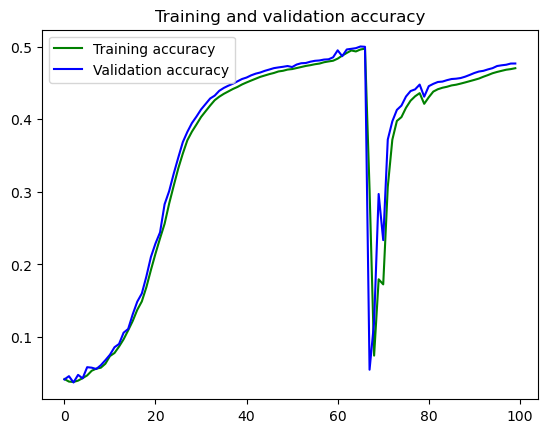

<Figure size 640x480 with 0 Axes>

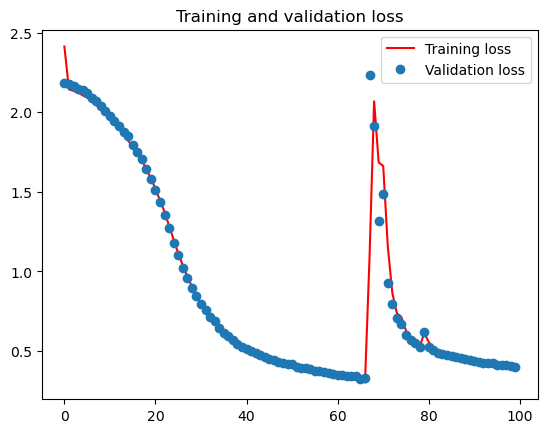

<Figure size 640x480 with 0 Axes>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('wordA.png')
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('wordL.png')
plt.figure()
plt.show()

In [17]:
from tensorflow import keras
from keras.models import load_model
from keras.layers import Input, LSTM, Dense
from keras.models import Model
#training_model = load_model('/content/drive/My Drive/MachineTranslation/training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
      #Predicting output tokens with probabilities and states
      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
#Choosing the one with highest probability
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      decoded_sentence += " " + sampled_token
#Stop if hit max length or found the stop token
      if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True
#Update the target sequence
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      #Update states
      states_value = [hidden_state, cell_state]
    return decoded_sentence

In [3]:
class Translator:
    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")

    def start(self, input_file_path):
        output_file_path = input("Enter the path for the output text file: ")
        self.translate_file(input_file_path, output_file_path)

    def translate_file(self, input_file_path, output_file_path):
        try:
            with open(input_file_path, 'r', encoding='utf-8') as input_file:
                with open(output_file_path, 'w', encoding='utf-8') as output_file:
                    for line in input_file:
                        line = line.strip()
                        if line:
                            hindi_translation = self.generate_response(line)
                            output_file.write(hindi_translation + '\n')
                    print(f"Translations written to {output_file_path}")
        except FileNotFoundError:
            print(f"Error: File not found - {input_file_path}")

    def generate_response(self, text):
        # This is a placeholder function. Replace this with actual translation logic.
        return "Translated text of: " + text

# Example usage in another program:
def get_input_file_path():
    # This function would get the input file path from another program.
    # Replace this with the actual logic to obtain the file path.
    return "path/to/input_file.txt"

# Get the input file path from another program
input_file_path = get_input_file_path()

# Create a Translator instance and start the translation process
translator = Translator()
translator.start(input_file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━